In [607]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for working with .nc files
import netCDF4 as nc

# for reading shapefiles .shp
import shapefile

# for working with polygons
from matplotlib import path
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# for working with netcdf
import xarray as xr
import xarray.ufuncs as xu

# for making movies / animations 
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

# working with datetimes
from datetime import datetime
import datetime as dt

# for calculating SPI
from standard_precip.spi import SPI
import scipy.stats as stats

# for parrallelising code
from multiprocessing import Pool
import multiprocessing as mp
from tempfile import mkdtemp
from joblib import Parallel, delayed

# 1. Read in `.nc` file

on the SoGE server: `cdo sellonlatbox,35,46,5,15 africa_chirps_final.nc africa_chirps_final_awash.nc`

In [3]:
# data_dir = "/Users/TommyLees/Desktop/chirps_data/africa_chirps_final_141516_awash.nc"
data_dir = "/Users/TommyLees/Desktop/chirps_data/awash_analysis/africa_chirps_final_awash.nc"
chirps = nc.Dataset(data_dir,'r')
chirps.variables['precip']

<class 'netCDF4._netCDF4.Variable'>
float32 precip(time, latitude, longitude)
    standard_name: convective precipitation rate
    long_name: Climate Hazards group InfraRed Precipitation with Stations
    units: mm/month
    _FillValue: -9999.0
    missing_value: -9999.0
    time_step: month
    geostatial_lat_min: -50.0
    geostatial_lat_max: 50.0
    geostatial_lon_min: -180.0
    geostatial_lon_max: 180.0
unlimited dimensions: time
current shape = (432, 200, 220)
filling on

In [7]:
precip = np.array(chirps.variables['precip'])
lat = np.array(chirps.variables['latitude'])
lon = np.array(chirps.variables['longitude'])
time = np.array(chirps.variables['time'])

In [10]:
dataset = xr.open_dataset(data_dir) #, chunks={'time':108,'latitude':100, 'longitude':110}) - REMOVE FOR SPI package
datetime_ = numpy.array(dataset.time)

In [11]:
mth = 1
ts = pd.to_datetime(str(datetime_[mth])) 
d = ts.strftime('%Y-%m-%d')
d

'1981-02-01'

# 2. Read in `.shp` file

In [12]:
shp_dir = '/Users/TommyLees/Desktop/chirps_data/awash_analysis/awash_shp/Export_Output.shp'
sf = shapefile.Reader(shp_dir)

In [13]:
bbox = sf.bbox
# print(bbox)
shape = sf.shapes()[0]
poly_points = shape.points
poly_path = path.Path(poly_points)

In [14]:
latmin = bbox[0]
lonmin = bbox[1]
latmax = bbox[2]
lonmax = bbox[3]

# 3. Create grid of lat, lon points

In [15]:
# create points (EQUIVALENT METHODS)
xx, yy = np.meshgrid(lon, lat)
xx, yy = xx.flatten(), yy.flatten()
points = np.array((xx, yy)).T
points2 = np.vstack((xx, yy)).T

# print(points.shape)

# 4. Check if points are inside Awash `.shp`

In [16]:
# this takes the longest!
flags = poly_path.contains_points(points)
# flags2 = poly_path.contains_points(points2)

# 5. Plot the in / out pixels

In [17]:
ymin = 55
ymax = 144
xmin = 58
xmax = 165

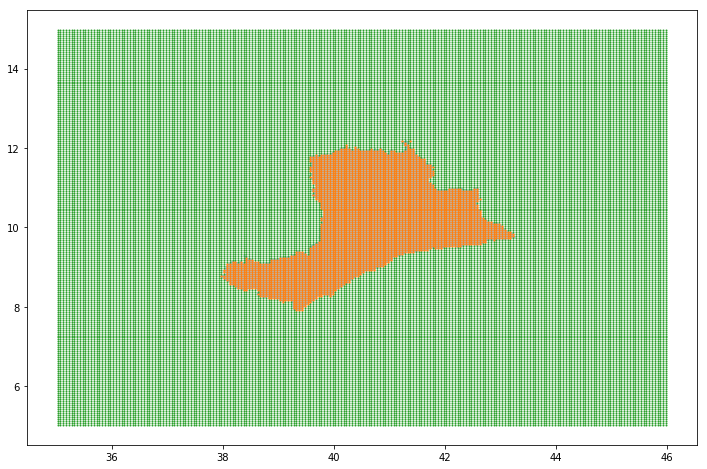

In [18]:
figsize(12,8)
fig,ax = plt.subplots(1,1)

# plot the polygon
p = PatchCollection([Polygon(poly_points)], alpha=0.4)
ax.add_collection(p)

# plot grid points
ax.scatter(xx[flags],yy[flags],2,color="C1") # points INside = the values TO KEEP
ax.scatter(xx[~flags],yy[~flags],1,color="C2") # points OUTside = the values TO MASK

# Mask the precip array
#### HOW TO ADD FURTHER CONDITIONS? i.e. masking values of -9999
`mask = np.logical_or( first_mask, second_mask )`

NOTE: `mask = True` for values that you are excluding

In [19]:
shape_mask = flags.reshape(200,220)
# NOTE: need to invert this in order to use as a mask

In [20]:
# points.shape

In [21]:
# points_grid = points.reshape(200,220,2)

In [22]:
time_len = precip.shape[0]

# repeat the mask for all time steps 
shapemask_t = np.array([~shape_mask]*time_len)

# exclude negative (MISSING) values (e.g. -9999)
precip_mask = np.ma.array(precip, mask=np.logical_or(shapemask_t, precip < 0))

## Check the mask has worked!

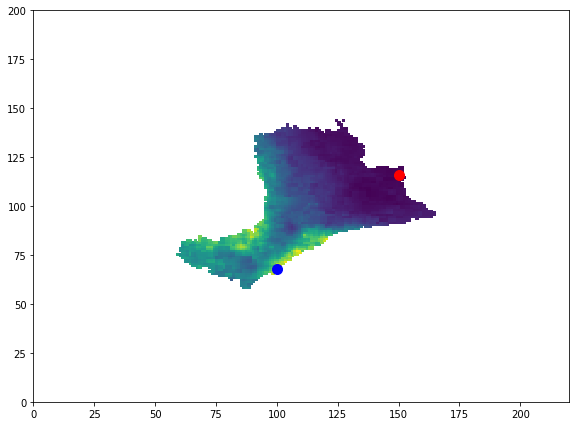

In [23]:
figsize(12*0.8,9*0.8)
fig,ax = plt.subplots()
ax.pcolormesh(precip_mask[30,:,:])

precip_t30 = precip_mask[30,:,:]
# what pixels have max/min
# NOTE: have to swap the indexes (0,1) -> (1,0)
ix_min = np.unravel_index(ma.MaskedArray.argmin(precip_t30), precip_t30.shape)
ix_max = np.unravel_index(ma.MaskedArray.argmax(precip_t30), precip_t30.shape)
plt.plot(ix_min[1], ix_min[0], 'ro', markersize=10, linewidth=10, label="minimum precip")
plt.plot(ix_max[1], ix_max[0], 'bo', markersize=10, linewidth=10, label="maximum precip")

# plt.xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
plt.show()

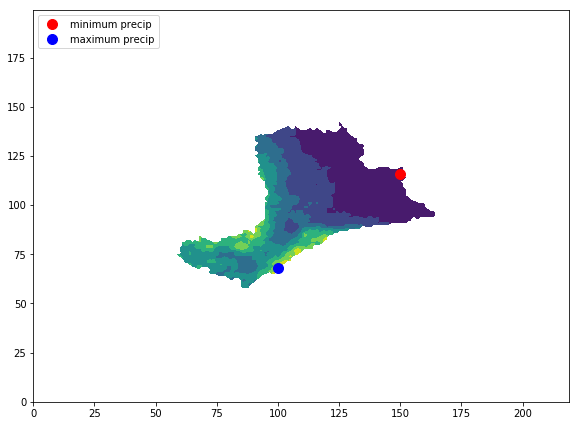

In [24]:
# Plot timestep 30
fig,ax = plt.subplots()
ax.contourf(precip_t30)
# plt.colorbar()

# which pixels have max / min?
ix_min = np.unravel_index(ma.MaskedArray.argmin(precip_t30), precip_t30.shape)
ix_max = np.unravel_index(ma.MaskedArray.argmax(precip_t30), precip_t30.shape)
plt.plot(ix_min[1], ix_min[0], 'ro', markersize=10, linewidth=10, label="minimum precip")
plt.plot(ix_max[1], ix_max[0], 'bo', markersize=10, linewidth=10, label="maximum precip")

# plt.ylim(55, 144)
# plt.xlim(58, 165)
plt.legend(loc="upper left")
plt.show()

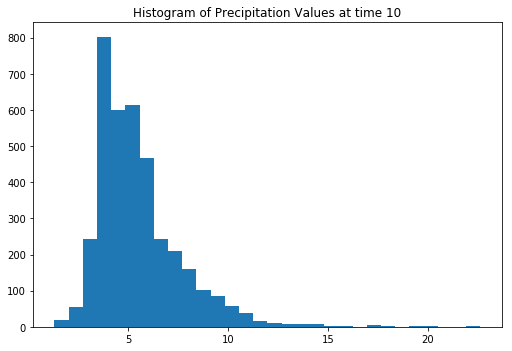

In [617]:
figsize(12*0.70, 8*0.70)
fig, ax = plt.subplots()

time_step = 10
precip_t = precip_mask[time_step,:,:]
precip_t_flat = ma.MaskedArray.flatten(precip_t)
ax.hist(precip_t.flatten()[~precip_t_flat.mask], bins=30)
plt.title('Histogram of Precipitation Values at month {}'.format(time_step))
plt.show()

In [26]:
print(precip_t30.min())
# unravel index is doing something weird
min_ix = np.unravel_index(precip_t30.argmin(), precip_t30.shape)
print(min_ix)
print(precip_t30[min_ix])

8.44929
(116, 150)
8.44929


In [27]:
# Try and reproduce the error
# INDEXES HAD TO BE SWAPPED lol
mask = [[True, True, False, False], [True, True, False, False]]
array = np.array([[1, 4, 3, 8], [2, 5, 7, 9]])
masked_array = np.ma.array(array, mask=mask)

print(array.min())
print(masked_array.min())

min_ix = np.unravel_index(masked_array.argmin(), masked_array.shape)
print(min_ix)

1
3
(0, 2)


## Are the minimums the same? `np.ma` == `array[mask]`?

In [28]:
precip_t = precip[0,:,:]
precip_mask_t = precip_mask[0,:,:]

In [29]:
np.min(precip_t[shape_mask])

0.96058333

In [30]:
precip_mask_t.min()

0.96058333

In [31]:
precip_mask_t.min() == np.min(precip_t[shape_mask])

True

# Where are the minimum and maximum values

In [32]:
# def get_max_min_indexes(precip_mask, plot=False, fig=None, ax=None):
#     min_indexes = []
#     max_indexes = []
#     n_timesteps = precip_mask.shape[0]
    
#     for t in range(n_timesteps):
#         # get the precip data @ time t
#         precip_mask_t = precip_mask[t,:,:]
#         # get the matrix index for the MIN value @ t
#         ix_min = np.unravel_index(ma.argmin(precip_mask_t), precip_mask_t.shape)
#         # get the matrix index for the MAX value @ t
#         ix_max = np.unravel_index(ma.argmax(precip_mask_t), precip_mask_t.shape)
#         min_indexes.append(ix_min)
#         max_indexes.append(ix_max)
    
#     if plot:
#         # if need to plot the data
#         for i in range(len(min_indexes)):
#         ix_min = min_indexes[i]
#         ix_max = max_indexes[i]
#         plt.plot(ix_min[1], ix_min[0], 'rx', alpha=0.8, label="minimum precip" if i == 0 else "")
#         plt.plot(ix_max[1], ix_max[0], 'ro', alpha=0.8, label="maximum precip"if i == 0 else "")
        
#         # return the fig, ax
#         return min_indexes, max_indexes, fig, ax
    
#     # otherwise just return the min/max indexes
#     return min_indexes, max_indexes
    

In [33]:
# what are the min / max / mean values for each month
min_max_dict = {"timestep":[], "min rainfall (mm/month)":[], "max rainfall (mm/month)":[], "mean rainfall (mm/month)":[], "month":[], "dtime":[]}
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]
# datetime_ object contains the Datetime

for t in range(precip_mask.shape[0]):
    precip_mask_t = precip_mask[t,:,:]
    minimum = np.ma.min(precip_mask_t)
    maximum = np.ma.max(precip_mask_t)
    mean = np.ma.mean(precip_mask_t)
    median = np.ma.median(precip_mask_t)
    month = months[t%12]
    dtime = datetime_[t]
    
    # append the values
    min_max_dict["timestep"].append(t)
    min_max_dict["min rainfall (mm/month)"].append(minimum)
    min_max_dict["max rainfall (mm/month)"].append(maximum)
    min_max_dict["mean rainfall (mm/month)"].append(mean)
    min_max_dict["month"].append(month)
    min_max_dict["dtime"].append(dtime)

In [34]:
# ?df.to_csv

df = pd.DataFrame(min_max_dict)
df.to_csv('/Users/TommyLees/Desktop/chirps_data/awash_analysis/figures/max_min_monthly.csv')
df = df.set_index("dtime", drop=True)
df = df.set_index(pd.to_datetime(df.index, infer_datetime_format=True))

In [35]:
min_indexes = []
max_indexes = []
for t in range(precip_mask.shape[0]):
    # get the precip data @ time t
    precip_mask_t = precip_mask[t,:,:]
    # get the matrix index for the MIN value @ t
    ix_min = np.unravel_index(ma.argmin(precip_mask_t), precip_mask_t.shape)
    # get the matrix index for the MAX value @ t
    ix_max = np.unravel_index(ma.argmax(precip_mask_t), precip_mask_t.shape)
    min_indexes.append(ix_min)
    max_indexes.append(ix_max)

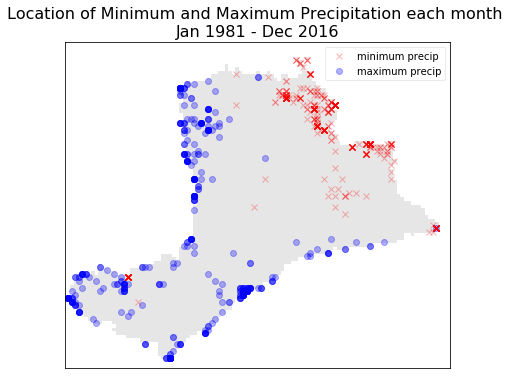

In [37]:
fig_scale = 0.5
figsize(18* fig_scale,12* fig_scale)
fix, ax = plt.subplots()

# ax.contourf(shape_mask, colors="grey", alpha=0.1)
# ax.pcolormesh(shape_mask, cmap="Greys", alpha = 0.1, edgecolors="None")
plt.imshow(shape_mask, alpha = 0.1, cmap="Greys")

for i in range(len(min_indexes)):
    ix_min = min_indexes[i]
    ix_max = max_indexes[i]
    plt.plot(ix_min[1], ix_min[0], 'rx', alpha=0.3, label="minimum precip" if i == 0 else "")
    plt.plot(ix_max[1], ix_max[0], 'bo', alpha=0.3, label="maximum precip"if i == 0 else "")

plt.ylim(55, 148)
plt.xlim(58, 168)
plt.legend(framealpha=0.4)
plt.title('Location of Minimum and Maximum Precipitation each month \nJan 1981 - Dec 2016', fontsize=16)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# plt.suptitle("Mean Precipitation (mm/month) each month", fontsize=16)
# plt.savefig('/Users/TommyLees/Desktop/chirps_data/awash_analysis/figures/loc_max_min_each_month')

In [38]:
# ?ax.contourf
# ?ax.pcolormesh
# ?plt.legend
# ?plt.imshow

## Can i show anomalies? so the same as above - anomalies above and below the points

## Look at the monthly profiles?

In [39]:
precip_mask.shape

(432, 200, 220)

In [40]:
tsteps = precip_mask.shape[0]
yrs = int(tsteps/12)
print(yrs)

# get every JANUARY
jan_precip = precip_mask[0::12,:,:]
# take a lat/lon mean value
jan_precip.shape
jan_precip.mean(axis=0).shape

# get every FEBRURARY
# precip_mask[1::12,:,:].shape

36


(200, 220)

In [41]:
# New array of monthly means (ACROSS ALL YEARS = Climatology)
# BUT it is setting the masked parts to 0
mthly_means = np.empty([12,200,220])
for mth in range(12):
    monthly_precip = precip_mask[mth::12,:,:]
    mth_mean = monthly_precip.mean(axis=0)
    mthly_means[mth] = mth_mean

# REMASK THE NEW ARRAY
mth_shape_mask = np.array([~shape_mask]*12)
mthly_means_ma = np.ma.array(mthly_means, mask=np.logical_or(mth_shape_mask, mthly_means < 0))
np.array([~shape_mask]).flatten().shape

(44000,)

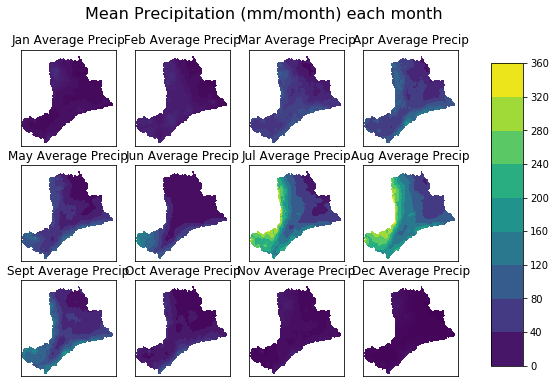

In [44]:
figscale = 0.5
figsize(18*figscale, 12*figscale)
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]
vmin = 0
vmax = 350

fig, axarr = plt.subplots(3,4)

for mth in range(13):
    # need this if statement to have the FIXED / CORRECT values for the colorbar
    # plotting the August precip LAST because need it for the fig.colorbar below!
    if mth == 12:
        mth = 7
        
    ax_ix = np.unravel_index(mth, (3,4))
    ax = axarr[ax_ix[0], ax_ix[1]]
    # NB use the MASKED ARRAY for plotting shapes
    im = ax.contourf(mthly_means_ma[mth], vmin=vmin, vmax=vmax)
    ax.set_title("%s Average Precip" % months[mth])

    # hide the axes labels (meaningless dims)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # zoom in to the correct area
    ax.set_ylim(55, 148)
    ax.set_xlim(58, 168)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.autoscale(tight=True)
plt.suptitle("Mean Precipitation (mm/month) each month", fontsize=16)
# plt.savefig('/Users/TommyLees/Desktop/chirps_data/awash_analysis/figures/avg_precip_per_month')
plt.show()

In [45]:
shp_msk = mthly_means_ma.mask#.flatten()#.tolist()
mth=0

mthly_means_na = mthly_means.copy()
mthly_means_na[~shp_msk] = numpy.nan

# data = mthly_means[mth].flatten()

In [46]:
precip_t30_flat = precip_t30.flatten()

In [47]:
fig_scale = 0.5

figsize(18*fig_scale, 12*fig_scale)
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]

fig, axarr = plt.subplots(3,4, sharex='all', sharey='all')

ax.hist(precip_t30.flatten()[~precip_t30_flat.mask])

for mth in range(12):
    ax_ix = np.unravel_index(mth, (3,4))
    ax = axarr[ax_ix[0], ax_ix[1]]
    data = mthly_means[mth].flatten()
    ax.hist(data[data>0], histtype='stepfilled', normed=False, bins='auto')
    
    ax.set_title(f"{months[mth]} Average Precip")

plt.autoscale(tight=True)
plt.suptitle("Mean Distribution of Precipitation (mm/Month/pixel)", fontsize=16)
# plt.savefig('/Users/TommyLees/Desktop/chirps_data/awash_analysis/figures/histogram_per_month')
plt.show()

SyntaxError: invalid syntax (<ipython-input-47-83ee613364ae>, line 16)

/Users/TommyLees/anaconda3/envs/spi/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'{Jan} Average Precip')

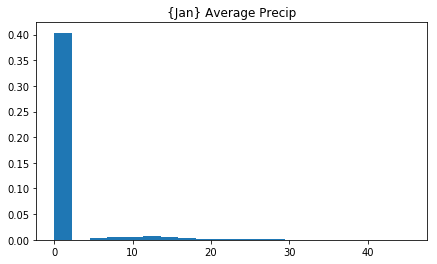

In [49]:
figsize(7,4)
fig, ax = plt.subplots()
mth = 0
data = mthly_means[mth].flatten() 

data = mthly_means[mth].flatten()
ax.hist(data[~np.isnan(data)], histtype='stepfilled', normed=True, bins=20)
# ax.set_title(f"{months[mth]} Average Precip")
ax.set_title("{%s} Average Precip" % months[mth])

## Normalised and 3,4 to show the months that are more similar
- the y axis is fixed for each ROW (so 3 monthly peridos have the same scale)

### NOTE: this doesn't work in the conda env spi

In [ ]:
figsize(18*0.5, 12*0.5)
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]

fig, axarr = plt.subplots(4,3, sharex='all', sharey='row')

ax.hist(precip_t30.flatten()[~precip_t30_flat.mask])

for mth in range(12):
    ax_ix = np.unravel_index(mth, (4,3))
    ax = axarr[ax_ix[0], ax_ix[1]]
    data = mthly_means[mth].flatten()
    ax.hist(data[data>0], histtype='stepfilled', normed=True, bins='auto')
    
#     ax.set_title(f"{months[mth]} Average Precip")
    ax.set_title("%s Average Precip" %months[mth])

plt.autoscale(tight=True)
plt.suptitle("Normalised Mean Distribution of Precipitation (mm/Month/pixel)", fontsize=16)
# plt.savefig('/Users/TommyLees/Desktop/chirps_data/awash_analysis/figures/histogram_per_month_normed2')
plt.show()

In [ ]:
figsize(18*0.5, 12*0.5)
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]

fig, axarr = plt.subplots(3,4, sharex='all', sharey='all')

ax.hist(precip_t30.flatten()[~precip_t30_flat.mask])

for mth in range(12):
    ax_ix = np.unravel_index(mth, (3,4))
    ax = axarr[ax_ix[0], ax_ix[1]]
    data = mthly_means[mth].flatten()
    ax.hist(data[data>0], histtype='stepfilled', normed=True, bins='auto')
    
#     ax.set_title(f"{months[mth]} Average Precip")
    ax.set_title("%s Average Precip" %months[mth])

plt.autoscale(tight=True)
plt.suptitle("Normalised Mean Distribution of Precipitation (mm/Month/pixel)", fontsize=16)
# plt.savefig('/Users/TommyLees/Desktop/chirps_data/awash_analysis/figures/histogram_per_month_normed1')
plt.show()

# Calculate the divergences from the mean!

In [43]:
print(precip_mask.shape)
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]

(432, 200, 220)


## calculate the mean value for each point in a particular month 
i.e. 
- the MEAN value at (lat,lon) in January
- the MEAN value at (lat,lon) in Feburary

OUT: (12, 200, 220)

In [44]:
mthly_means = np.empty([12,200,220])
precip_t = precip_mask[0]
for mth in range(12):
    monthly_precip = precip_mask[mth::12,:,:] # get every year for that month
    mth_mean = monthly_precip.mean(axis=0)
    mthly_means[mth] = mth_mean

# REMASK THE NEW ARRAY
mth_shape_mask = np.array([~shape_mask]*12)
mthly_means = np.ma.array(mthly_means, mask=np.logical_or(mth_shape_mask, mthly_means < 0))

print(type(mthly_means))
print(mthly_means.shape)

<class 'numpy.ma.core.MaskedArray'>
(12, 200, 220)


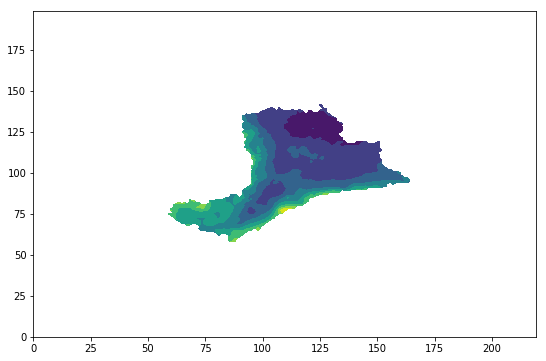

In [45]:
plt.contourf(mthly_means[8,:,:])

## cacluate the divergence from that mean for each original point!

- precip_mask[0, :, :] - mean value at (lat,lon) in January

In [46]:
timesteps = precip.shape[0]
shapemask_t = np.array([~shape_mask]*timesteps)

In [47]:
month_mean_raw = np.empty([12,200,220])
precip_anomaly_raw = np.empty([432,200,220])

# CALCULATE THE MONTH MEAN
for mth in range(12):
    monthly_precip = precip[mth::12,:,:] # get every yearly ts for that month (Jan 1980, Jan 1981, ...)
    mth_mean = monthly_precip.mean(axis=0)
    month_mean_raw[mth] = mth_mean

# CALCULATE THE ANOMALY FROM MONMEAN AT EACH TIMESTEP
for ts in range(timesteps):
    ts_anomaly = precip[ts, :, :] - month_mean_raw[ts % 12, :, :]
    precip_anomaly_raw[ts] = ts_anomaly

print(month_mean_raw.shape)
print(precip_anomaly_raw.shape)

# NOW MASK the array
precip_anomaly = np.ma.masked_array(precip_anomaly_raw, mask=np.logical_or(shapemask_t, precip < 0))

(12, 200, 220)
(432, 200, 220)


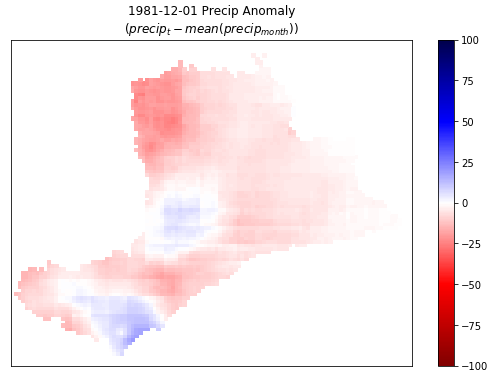

In [48]:
vmin = -100
vmax = +100
fig, ax = plt.subplots()

ts = 1
data = precip_anomaly[ts, :, :]
im = ax.pcolormesh(data, cmap='seismic_r', vmin=vmin, vmax=vmax)
dtim = pd.to_datetime(str(datetime_[mth])) 
d = dtim.strftime('%Y-%m-%d')
# d = datetime_[ts]
ax.set_title(f"{d} Precip Anomaly\n" + "($ precip_{t} - mean(precip_{month}) $)")
# hide the axes labels (meaningless dims)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# zoom in to the correct area
ax.set_ylim(55, 148)
ax.set_xlim(58, 168)

fig.colorbar(im)
plt.show()

In [49]:
mth = 1
datetime_[mth]
dtim = pd.to_datetime(str(datetime_[mth])) 
d = dtim.strftime('%Y-%m-%d')
print(d)

1981-02-01


# Plot every timestep

In [53]:
n_ts = precip_anomaly.shape[0]
n_ts = 4
zi = np.array([[-100.0,0.0, 100.0],
               [-100.0, 0.0, 100.0],
               [-100.1, 0.0, 100.0]])

for ts in range(n_ts):
    fig, ax = plt.subplots()
    
    data = precip_anomaly[ts, :, :]
    im = ax.contourf(data, cmap='seismic_r', vmin=vmin, vmax=vmax)

    dtim = pd.to_datetime(str(datetime_[ts])) 
    d = dtim.strftime('%Y-%m-%d')
    ax.set_title(f"{d} Precip Anomaly\n" + "($ precip_{t} - mean(precip_{month}) $)")
    
    # hide the axes labels (meaningless dims)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # zoom in to the correct area
    ax.set_ylim(55, 148)
    ax.set_xlim(58, 168)
    
    fig.colorbar(im)
#     fig.savefig(f'/Users/TommyLees/Desktop/chirps_data/awash_analysis/figures/plots/{d}', dpi=150)
#     plt.show()
    plt.close()
    pass

2016


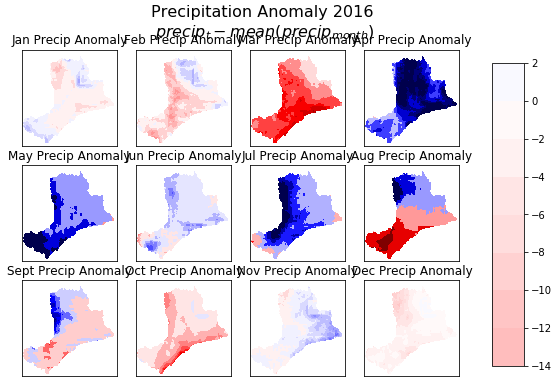

CPU times: user 1.77 s, sys: 46.6 ms, total: 1.81 s
Wall time: 1.82 s


In [87]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]
# year_start = 2015
years = range(year_start, 2017)

vmin = -100
vmax = +100

def create_annual_anomaly_plots(year_start=2016, savefig=True, fig_scale=1):
    figsize(18*fig_scale, 12*fig_scale)
    while year_start < 2017:
        # 1981 = 0, 2016 = 36
        i = 1 * (year_start - 1981)
        print(year_start)
        
        fig, axarr = plt.subplots(3,4, sharex='all', sharey='all')
        precip_anomaly_yr = precip_anomaly[i*12 : (i*12)+12, :, :]
        i += 1
        
        yr = year_start
        for ts in range(precip_anomaly_yr.shape[0]):
                
            # get the axis to plot the awash map
            mnth = ts % 12
            ax_ix = np.unravel_index(mnth, (3,4))
            ax = axarr[ax_ix[0], ax_ix[1]]

            # NB use the MASKED ARRAY for plotting shapes
            data = precip_anomaly_yr[ts, :, :]
            im = ax.pcolormesh(data, cmap='seismic_r', vmin=vmin, vmax=vmax)

            # get the datetime for the header
            dtim = pd.to_datetime(str(datetime_[ts])) 
            d = dtim.strftime('%Y-%m-%d')
            ax.set_title(f"{months[mnth]} Precip Anomaly")

            # hide the axes labels (meaningless dims)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            # zoom in to the correct area
            ax.set_ylim(55, 148)
            ax.set_xlim(58, 168)

        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)
        plt.autoscale(tight=True)
        plt.suptitle(f"Precipitation Anomaly {year_start} \n" + "$ precip_{t} - mean(precip_{month}) $", fontsize=16)
        year_start += 1
        if savefig:
            fig.savefig(f'/Users/TommyLees/Desktop/chirps_data/awash_analysis/figures/plot_yrs/{yr}', dpi=150)
        else:
            plt.show()
        plt.close()
        
%time create_annual_anomaly_plots(2016, False, 0.5)

# Create Movie!

In [80]:
%run plot_movie.py

In [79]:
pwd

'/Users/TommyLees/Desktop/chirps_data/awash_analysis'

3


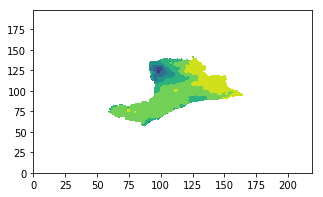

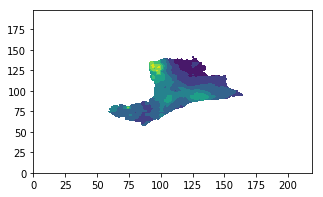

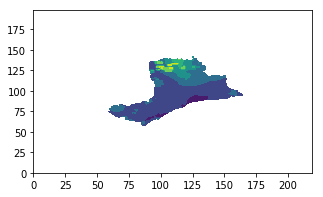

In [66]:
figsize(5, 3)
i = 0
data = precip_anomaly[i*12 : (i+2*12)+12, :, :]
data = data[i::12, :, :]
print(data.shape[0])

for ts in range(data.shape[0]):
    plt.contourf(data[ts,:,:])
    plt.show()

# Get the maximum and minimum each month

In [87]:
data_dir = "/Users/TommyLees/Desktop/chirps_data/awash_analysis/africa_chirps_final_awash.nc"
dataset = xr.open_dataset(data_dir) #, chunks={'time':108,'latitude':100, 'longitude':110})
dataset

<xarray.Dataset>
Dimensions:    (latitude: 200, longitude: 220, time: 432)
Coordinates:
  * longitude  (longitude) float32 35.025 35.075 35.125 35.175 35.225 35.275 ...
  * latitude   (latitude) float32 5.025 5.075 5.125 5.175 5.225 5.275 5.325 ...
  * time       (time) datetime64[ns] 1981-01-01 1981-02-01 1981-03-01 ...
Data variables:
    precip     (time, latitude, longitude) float64 4.253 4.709 4.897 5.36 ...
Attributes:
    CDI:               Climate Data Interface version ?? (http://mpimet.mpg.d...
    history:           Wed May 09 09:59:34 2018: cdo sellonlatbox,35,46,5,15 ...
    institution:       Climate Hazards Group.  University of California at Sa...
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    version:           Version 2.0
    date_created:      2018-01-17
    creator_name:      Pete Peterson
    creator_email:     pete@geog.ucsb.edu
    documentation:     http://pubs.usgs.gov/ds/832/
    reference:         Funk, C.C., Peterson, P.J., Lands

In [89]:
dataset.time.data[:5]

array(['1981-01-01T00:00:00.000000000+0000',
       '1981-02-01T00:00:00.000000000+0000',
       '1981-03-01T00:00:00.000000000+0000',
       '1981-04-01T01:00:00.000000000+0100',
       '1981-05-01T01:00:00.000000000+0100'], dtype='datetime64[ns]')

# SPI
https://github.com/e-baumer/standard_precip

In [325]:
spi = SPI()

In [326]:
spi.set_rolling_window_params(
    span=3, window_type=None, center=True
)

In [327]:
# dist_type = 'gam'
spi.set_distribution_params(dist_type='gam')

In [328]:
# get rainfall data for time=:, lat=0, lon=0
# i.e. the FIRST PIXEL over time
rainfall_data = precip[:,0,0] 
print(rainfall_data.shape)

# Input data for ALL (each pixel is a column)
print(precip.shape)
precip_reshape = precip.reshape(432, 200 * 220)

print(precip_reshape[0, :5])
print(precip[0, 0, :5])
print(precip_reshape.shape)

(432,)
(432, 200, 220)
[ 4.25317001  4.7092495   4.89744473  5.36022758  5.63421965]
[ 4.25317001  4.7092495   4.89744473  5.36022758  5.63421965]
(432, 44000)


In [329]:
rainfall_data_all = precip_reshape

In [331]:
data = spi.calculate(rainfall_data, starting_month=1).flatten()

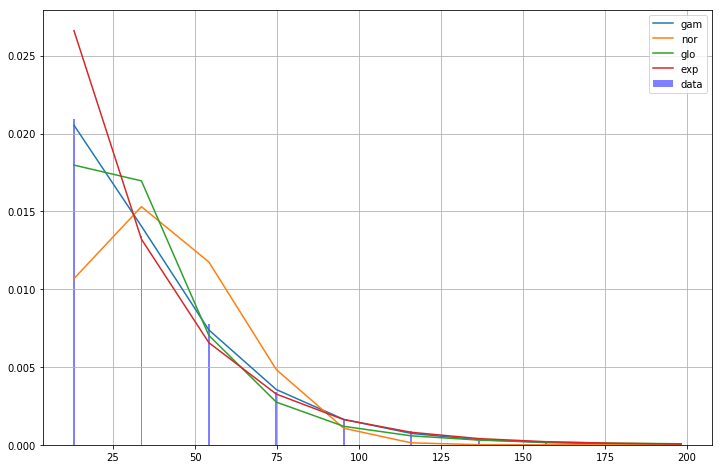

{'exp': 3.3722705447807381e-05,
 'gam': 8.2755260564355091e-07,
 'glo': 2.2838708117345523e-05,
 'nor': 0.00012799369222185505}

In [511]:
spi.best_fit_distribution(rainfall_data, ['gam', 'nor', 'glo', 'exp'])

In [512]:
data_all

False

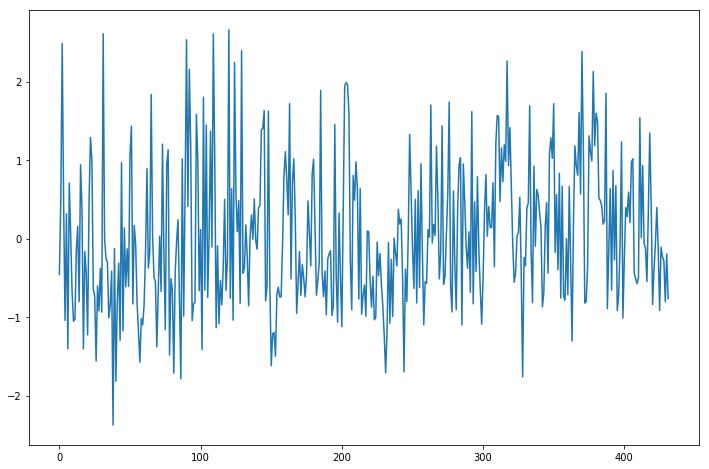

In [375]:
#spi over time
n_dates = [i for i in range(len(data))]
plt.plot(n_dates, data)

# Get inside the SPI Functions

In [396]:
data_ = rainfall_data
n_months = rainfall_data.shape[0]
start_month=1
span=3
window_type=None
center=True
spi = SPI()
dist_type='gam'

from lmoments3 import distr
spi.distrb = getattr(distr, dist_type)

# calculate the number of months
start = start_month - 1
end = n_months + start_month - 1

months = [(dt.datetime(2000, 1, 1) + relativedelta(months=i)).month
          for i in range(start, end)]

# calculate SPI
mnth_list = np.array(months)
spi_ = np.zeros(np.shape(data))*np.nan # allocate memory to SPI

# for single point timeseries
if data_.ndim == 1:
    data_ = data_.reshape(len(data_), 1) # turn into a  column vector (432, 1)
    spi_ = spi_.reshape(len(spi_), 1) # reshape spi too

for i in range(np.shape(data_)[1]): # for each column (PIXEL) in rainfall data
    data_one_series = np.copy(data_[:, ]) # , i]) # create a unique column vector for that pixel
    
    # get the window mean IF WINDOW TYPE is NOT NONE
    if spi.window_type:
        data_one_series = spi.rolling_window_mean(
            data_one_series, self.span, self.window_type,
            self.rw_center, **self.rw_kwargs
        )
    
    data_dict = {}
    params_dict = {}
    month_list = ['January', 'Feburary', 'March', 'April', 'May', 'June', 'July', 'August',
                  'September', 'October', 'November', 'December']
    for j in range(1, 13):
        
        spi.distr = 'gam'
        mnth_inds = np.where(mnth_list == j)[0]

        if len(mnth_inds) == 0:
            continue

        data_month = data_one_series[mnth_inds]

        # Find all nans in data and remove for fitting distribution
        nan_inds = np.where(np.isnan(data_month))[0] # find the NANs
        data_month = data_month[~np.isnan(data_month)] # select the NON-NAN values
        data_dict["{}".format(month_lst[j-1])] = data_month
        
        data_month_sorted = np.sort(data_month)[::-1] # order from HIGH:LOW
        data_dict["{}_sorted".format(month_list[j-1])] = data_month_sorted
        mnth_inds = np.delete(mnth_inds, nan_inds)

        # Fit distribution for particular series and month
        params = spi.fit_distribution(data_month_sorted, 'gam')
        params_dict[j] = params

        # Calculate SPI/SPEI
        spi_[mnth_inds, i] = spi.cdf_to_ppf(data_month, params)

In [397]:
# ?spi.distrb.lmom_fit()

In [398]:
pd.DataFrame(data_dict)
params_df = pd.DataFrame(params_dict)

In [399]:
# mth_order = ['January', 'Feburary', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
params_df 

,1,2,3,4,5,6,7,8,9,10,11,12
a,2.298856,1.615518,4.702905,5.665163,3.039404,2.293740,3.716759,2.007249,2.450151,3.721437,1.530345,1.324175
loc,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
scale,3.017440,11.656515,11.266619,11.356330,11.559894,12.910838,11.885844,20.048638,7.652328,7.435460,35.347149,22.686375


## For Pixel 1 visualise the different gamma distributions 

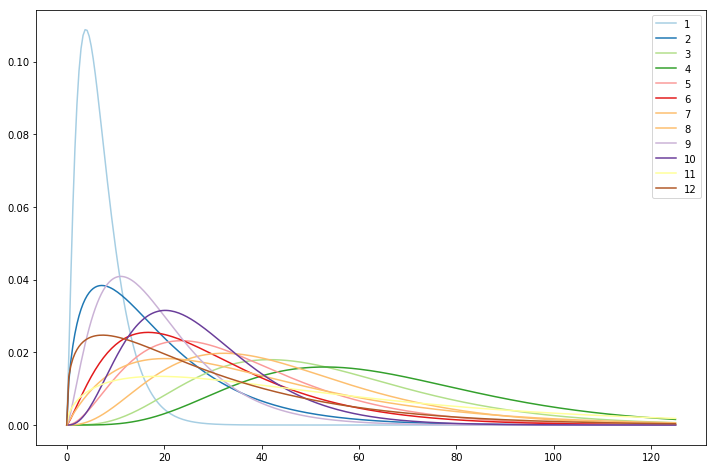

In [448]:
figscale = 1
figsize(12*figscale, 8*figscale)

x = np.linspace (0, 125, 300)
 
color = iter(cm.viridis_r(np.linspace(0,1,13)))
color_list = plt.cm.Paired(np.linspace(0, 1, 13))

for i, col in enumerate(params_df):
    a = params_df[col].a
    scale = params_df[col].scale
#     c = next(color)
    c = color_list[i]
    label = '{}'.format(col)
    
    y = stats.gamma.pdf(x, a=a, scale=scale)
    plt.plot(x, y, "y-", label = label, c=c)

plt.legend()
plt.show()    

# INTERACTIVE PLOTTING
- plotly
- bokeh

In [441]:
from bokeh.palettes import Category20 # load colors
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook

# load the bokeh plot to inline notebook
output_notebook()

x = np.linspace (0, 150, 400)
mth_order = ['January', 'Feburary', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# figsize and title
p = figure(plot_width=900, plot_height=500)
p.title.text = 'Gamma distributions for each month in pixel precip[:,0,0]'

for i, col in enumerate(params_df):
    
    a = params_df[col].a
    scale = params_df[col].scale
    c = Category20[12][i] # SET THE COLORS from a list
    label = mth_order[i]
    
    y = stats.gamma.pdf(x, a=a, scale=scale)
    
    p.line(x, y, legend=label, color=c, alpha=0.8, muted_alpha=0.1, muted_color=c, line_width=2)

p.legend.location = "top_right"
p.legend.click_policy="mute"

show(p)

Loading BokehJS ...

In [508]:
import plotly.plotly as py
import plotly.graph_objs as go
from bokeh.palettes import Category20

for i, col in enumerate(params_df):
    a = params_df[col].a
    scale = params_df[col].scale
    c = Category20[12][i] # SET THE COLORS from a list
    label = mth_order[i]
    
    # CREATE A NEW VARIABLE FOR EACH LINE
    globals()["trace_{}".format(col)] = go.Scatter(
        x = np.linspace (0, 150, 400),
        y = stats.gamma.pdf(x, a=a, scale=scale),
        mode = "lines",
        name=label
    )

data = [trace_1, trace_2, trace_3, trace_4, trace_5, trace_6, trace_7, trace_8,trace_9,trace_10,trace_11,trace_12]

py.iplot(data, filename='line-mode')

In [446]:
?plotly.graph_objs

Object `plotly.graph_objs` not found.


In [409]:
# color=iter(cm.viridis(np.linspace(0,1,12)))

array([[ 0.65098039,  0.80784314,  0.89019608,  1.        ],
       [ 0.12156863,  0.47058824,  0.70588235,  1.        ],
       [ 0.69803922,  0.8745098 ,  0.54117647,  1.        ],
       [ 0.2       ,  0.62745098,  0.17254902,  1.        ],
       [ 0.98431373,  0.60392157,  0.6       ,  1.        ],
       [ 0.89019608,  0.10196078,  0.10980392,  1.        ],
       [ 0.99215686,  0.74901961,  0.43529412,  1.        ],
       [ 0.99215686,  0.74901961,  0.43529412,  1.        ],
       [ 0.79215686,  0.69803922,  0.83921569,  1.        ],
       [ 0.41568627,  0.23921569,  0.60392157,  1.        ],
       [ 1.        ,  1.        ,  0.6       ,  1.        ],
       [ 0.69411765,  0.34901961,  0.15686275,  1.        ],
       [ 0.69411765,  0.34901961,  0.15686275,  1.        ]])

In [227]:
print(params)
from lmoments3 import distr
?distr.nor.ppf

In [210]:
print(params)
data_month

array([   7.07993364,   53.19158173,    7.26410103,   11.89885902,
          6.43969631,   23.60543823,   22.13819885,    9.20148849,
         68.45902252,   18.0146122 ,   15.56526184,   69.15135956,
         11.83413696,   29.54184532,   46.7236557 ,   18.9207058 ,
        100.02023315,   10.45105743,   18.92843628,   16.05767059,
         11.61481285,   84.52804565,   38.41702271,   34.98374176,
          6.51450634,   77.05172729,   14.43705082,    9.31432438,
         56.37718582,   22.89740753,   58.50350189,   35.49752808,
          8.1878109 ,   14.52058125,   34.19568253,    9.93836212], dtype=float32)

In [208]:
j = 1
mnth_inds = np.where(mnth_list == j)[0]
print(mnth_inds)

data_month_sorted

[  0  12  24  36  48  60  72  84  96 108 120 132 144 156 168 180 192 204
 216 228 240 252 264 276 288 300 312 324 336 348 360 372 384 396 408 420]


array([ 100.02023315,   84.52804565,   77.05172729,   69.15135956,
         68.45902252,   58.50350189,   56.37718582,   53.19158173,
         46.7236557 ,   38.41702271,   35.49752808,   34.98374176,
         34.19568253,   29.54184532,   23.60543823,   22.89740753,
         22.13819885,   18.92843628,   18.9207058 ,   18.0146122 ,
         16.05767059,   15.56526184,   14.52058125,   14.43705082,
         11.89885902,   11.83413696,   11.61481285,   10.45105743,
          9.93836212,    9.31432438,    9.20148849,    8.1878109 ,
          7.26410103,    7.07993364,    6.51450634,    6.43969631], dtype=float32)

In [130]:
print(rainfall_data.shape)
rainfall_data[:5]

(432,)


array([   4.25317001,   22.4441185 ,  132.44560242,   73.35293579,
         15.62693977], dtype=float32)

In [119]:
data_df = pd.DataFrame(rainfall_data)
span=3
window_type=None
center=True
data_df.shape # (432, 1) = 432 rows, 1 column

(432, 1)

In [202]:
window_sum = np.squeeze(data_df.rolling(window=span, win_type=window_type, center=center).sum().values.T)

rolling = data_df.rolling(window=span, win_type=window_type, center=center) # create a rolling object (window=3)
rolling_sum = rolling.sum() # calculate the sum over that window
rolling_sum_T = rolling_sum.values.T # convert into a row vector (432,1) -> (1,432)
window_sum_ = np.squeeze(rolling_sum_T) # flattens the array to 1D () -> (432,)

rolling_mean = rolling.mean()
rolling_mean_T = rolling_mean.values.T
window_mean_ = np.squeeze(rolling_mean_T)

In [203]:
print("\noriginal data\n",data_df[:5])
print("\nrolling mean\n", rolling_mean[:5])
print("\nrolling sum\n", rolling_sum[:5])

sum_window_one = 4.253170 + 22.444118 + 132.445602
mean_window_one = sum_window_one/3
print("\n",sum_window_one)
print(mean_window_one)


original data
             0
0    4.253170
1   22.444118
2  132.445602
3   73.352936
4   15.626940

rolling mean
            0
0        NaN
1  53.047630
2  76.080886
3  73.808493
4  40.182633

rolling sum
             0
0         NaN
1  159.142891
2  228.242657
3  221.425478
4  120.547899

 159.14289000000002
53.047630000000005


In [131]:
# ?np.squeeze
# x = np.array([[[0],[1],[2]]])
# print(x.shape)
# print(x)
# x.squeeze().shape
# print(x.squeeze().shape)
# print(x.squeeze())

In [132]:
# ?pd.DataFrame.rolling()
# rolling window calculations

In [137]:
print(spi.rolling_window_sum(data=rainfall_data, span=3, window_type=None, center=True)[:5])
print(window_sum_[:5])

# N.B nan != nan
# print(np.nan == np.nan)

[          nan  159.14289093  228.24265671  221.42547798  120.54789925]
[          nan  159.14289093  228.24265671  221.42547798  120.54789925]
False


In [115]:
pd.DataFrame(rainfall_data)[:5]

,0
0,4.253170
1,22.444118
2,132.445602
3,73.352936
4,15.626940


In [138]:
spi.dist_type

'gam'

In [373]:
spi.fit_distribution(rainfall_data, 'gam')

OrderedDict([('a', 1.5660098339742652),
             ('loc', 0),
             ('scale', 22.499434322322223)])

# SPI Functions - Definitions 

In [161]:
def __create_month_cycle(n_months, start_month=1):
    '''
    Create a repeating array of months 1-12, truncated by start_month
    Example:
             Create an array of 24 months starting on March (3)
             create_month_cycle(24, start_month=3)
             array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,
                     6,  7, 8,  9, 10, 11, 12,  1,  2])
    '''

    start = start_month - 1
    end = n_months + start_month - 1

    months = [(dt.datetime(2000, 1, 1) + relativedelta(months=i)).month
              for i in range(start, end)]

    return np.array(months)

################################################################################

def __rolling_window_mean(self, data, span, window_type, center, **kwargs):
        '''
        '''

        data_df = pd.DataFrame(data)

        window_mean = np.squeeze(data_df.rolling(
            window=span, win_type=window_type, min_periods=span,
            center=center, **kwargs
        ).mean().values.T)

        #weighted_mean = pd.rolling_window(
            #data, window=span, win_type=window_type, center=True,
            #mean=True, **kwargs
        #)

        return window_mean

#################################################################################

def __cdf_to_ppf(self, data, params):
    '''
    Take the specific distributions fitted parameters and calculate the
    cdf. Apply the inverse normal distribution to the cdf to get the SPI
    SPEI. This process is best described in Lloyd-Hughes and Saunders, 2002
    which is included in the documentation.
    '''

    # Calculate the CDF of observed precipitation on a given time scale
    cdf = self.distrb.cdf(data, **params)

    # Apply inverse normal distribution
    norm_ppf = distr.nor.ppf(cdf)

    return norm_ppf

#################################################################################

def __fit_distribution(self, data, dist_type, **kwargs):
    '''
    Fit given distribution to historical precipitation data.
    The fit is accomplished using MLE or Maximum Likelihood Estimation.
    One should put some thought into the type of distribution fit to the
    data. Precipitation can have zero value and some distributions are only
    defined over interval (0, inf). Python's gamma distribution is defined
    over [0, inf). In addition SPEI which is constructed from precipitation
    - PET or (P-PET) can take on negative values!!
    Check https://docs.scipy.org/doc/scipy/reference/stats.html for
    distribution types
    dist_type -- distribution type to fit
    data      -- Historical data to fit
    kwargs    -- scale and location parameters. See documentation on
                 scipy.stats.rv_continuous.fit
    Returns: shape, location, and scale (tuple of floats)
    '''

    # Get distribution type
    try:
        self.distrb = getattr(distr, dist_type)
    except AttributeError:
        print("{} is not a valid distribution type".format(dist_type))

    # Fit distribution
    params = self.distrb.lmom_fit(data, **kwargs)

    return params

#################################################################################

def __calculate_over_full_series(self, data, starting_month):

    # Number of months in data
    n_months = np.shape(data)[0]

    # Create month list
    # array of month numbers
    mnth_list = create_month_cycle(n_months, start_month=starting_month)

    # Pre-allocate SPI
    
    spi = np.zeros(np.shape(data))*np.nan

    # Single date series
    if data.ndim == 1:
        data = data.reshape(len(data), 1)
        spi = spi.reshape(len(spi), 1)

    # Loop over other series (non-time)
    for i in range(np.shape(data)[1]):
        data_one_series = np.copy(data[:, i])

        # Apply rolling window
        if self.window_type:
            data_one_series = self.rolling_window_mean(
                data_one_series, self.span, self.window_type,
                self.rw_center, **self.rw_kwargs
            )

        # Loop over months
        for j in range(1, 13):
            mnth_inds = np.where(mnth_list == j)[0]

            if len(mnth_inds) == 0:
                continue

            data_month = data_one_series[mnth_inds]

            # Find all nans in data and remove for fitting distribution
            nan_inds = np.where(np.isnan(data_month))[0]
            data_month = data_month[~np.isnan(data_month)]
            data_month_sorted = np.sort(data_month)[::-1]
            mnth_inds = np.delete(mnth_inds, nan_inds)

            # Fit distribution for particular series and month
            params = self.fit_distribution(data_month_sorted, self.dist_type, **self.dist_kwargs)

            # Calculate SPI/SPEI
            spi[mnth_inds, i] = self.cdf_to_ppf(data_month, params)

    return spi

#################################################################################

def __calculate(self, data, starting_month=1):
    '''
    First dimension of data should be time (months)
    '''

    # Check if distribution has been fit on historical data
    if self.dist_type is None:
        print ("You must fit a distribution first")
        return False

    if isinstance(data, types.GeneratorType):
        pass

    else:
        spi = self.calculate_over_full_series(data, starting_month)

    return spi

In [637]:
gamma_gen = spi.distrb # get the gamma generator from lmoments3
# params = gamma_gen.lmom_fit(data)

None


In [148]:
from lmoments3 import distr
# ??distr

getattr(distr, spi.dist_type)

In [450]:
from collections import Counter

In [454]:
c = Counter([0,1,2,2])
c

Counter({0: 1, 1: 1, 2: 2})

# visualise SPI over time for each pixel?

In [520]:
import sys
def print_progress(iteration, total, prefix='', suffix='', decimals=1, bar_length=100):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        bar_length  - Optional  : character length of bar (Int)
    """
    str_format = "{0:." + str(decimals) + "f}"
    percents = str_format.format(100 * (iteration / float(total)))
    filled_length = int(round(bar_length * iteration / float(total)))
    bar = '█' * filled_length + '-' * (bar_length - filled_length)

    sys.stdout.write('\r%s |%s| %s%s %s' % (prefix, bar, percents, '%', suffix)),

    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()

In [613]:
spi = SPI()
spi.set_distribution_params(dist_type='gam')
spi.set_rolling_window_params(span=3, window_type=None, center=True)

# data_all = np.empty_like(rainfall_data_all)
assert rainfall_data_all.shape[0] == 432, "NOTE: rainfall data does not have all months"

def run_spi():
    # progress bar
    iteration = 0
    timesteps = pixels = rainfall_data_all.shape[1]
    
    # loop over each pixel
    for i in range(timesteps):
        print_progress(iteration, timesteps)
        iteration += 1
        try:
            data_all[:,i] = spi.calculate(rainfall_data_all[:,i], starting_month=1).flatten()
        except:
            pass
    return data_all

# %time data_all = run_spi() 
# 25min 22s to run!

In [604]:
rainfall_data_all.shape[1]/4

11000.0

## Parallel SPI Calculation

In [771]:
def parallel_spi(dataset):
    # init variables for reading in
    iteration = 0
        
    print("2. dataset.shape", dataset.shape)
    pixels = dataset.shape[0]
    dataset_all = np.empty_like(dataset)
    
    # init SPI variable
    spi = SPI()
    spi.set_distribution_params(dist_type='gam')
    spi.set_rolling_window_params(span=3, window_type=None, center=True)
    
    for i in range(pixels):
        raw_precip_pixel_i = rainfall_data_all[:,i]
        print("3. dataset.shape", raw_precip_pixel_i.shape)
#         print_progress(iteration, pixels)
        iteration += 1
        try:
            pass
#             dataset_all[:,i] = spi.calculate(raw_precip_pixel_i, starting_month=1).flatten()
        except:
            pass
    return dataset_all

In [772]:
def run_parallel_spi():
    if __name__ == '__main__':
        # Define the dataset
        dataset = rainfall_data_all
        print("1. dataset.shape", dataset.shape)

        agents = mp.cpu_count()
        chunksize = None # rainfall_data_all.shape[0] * (rainfall_data_all.shape[1] / mp.cpu_count())
        with mp.Pool(processes=agents) as pool:
            result = pool.map(parallel_spi, dataset, chunksize)

        # Output the result
#         print ('Result:  ' + str(result))

In [ ]:
run_parallel_spi()

### Test Multiprocessing 

In [761]:
df = pd.DataFrame(rainfall_data_all)

def _function(x):
    return x*2

def test_parallel(data):
    if __name__ == '__main__':
        # Define the dataset
        dataset = np.array([[month+1]*4 for month in range(12)])

        agents = mp.cpu_count()
        chunksize = None # rainfall_data_all.shape[0] * (rainfall_data_all.shape[1] / mp.cpu_count())
        with mp.Pool(processes=agents) as pool:
            result = pool.map(_function, data, chunksize)

        # Output the result
        # print ('Result:  ' + str(len(result)))
        return np.array(result)
        
# dataset.shape
# (432, 44000) -> (432, 2200) * 20
# print(np.zeros((432, 2, 2)))
# np.array([[[ 0., 0.],[ 0.,  0.]] * 432]).shape
# [[[1,1],[1,1]], [[2,2],[2,2]], [[3,3],[3,3]]]
# np.array(4*[np.arange(12)+1]).shape
# [[1,2,3,4],[5,6,7,8],[9,10,11,12]] #np.array([arr for _ in range(432)])

data = np.array([[month+1]*4 for month in range(12)])
result = test_parallel(data)
print("original data shape", data.shape)
print("transposed data shape", data.T.shape)
print("Result: data shape", result.shape)
print("Data: \n{}".format(data))
print("Result: \n{}".format(result))

original data shape (12, 4)
transposed data shape (4, 12)
Result: data shape (12, 4)
Data: 
[[ 1  1  1  1]
 [ 2  2  2  2]
 [ 3  3  3  3]
 [ 4  4  4  4]
 [ 5  5  5  5]
 [ 6  6  6  6]
 [ 7  7  7  7]
 [ 8  8  8  8]
 [ 9  9  9  9]
 [10 10 10 10]
 [11 11 11 11]
 [12 12 12 12]]
Result: 
[[ 2  2  2  2]
 [ 4  4  4  4]
 [ 6  6  6  6]
 [ 8  8  8  8]
 [10 10 10 10]
 [12 12 12 12]
 [14 14 14 14]
 [16 16 16 16]
 [18 18 18 18]
 [20 20 20 20]
 [22 22 22 22]
 [24 24 24 24]]


In [718]:
arr = [[1,2],[3,4]]
np.array([arr for _ in range(432)]).shape

(432, 2, 2)

In [675]:
??pool.map
# rainfall_data_all.shape[0] * (rainfall_data_all.shape[1] / mp.cpu_count())

In [638]:
# %time run_parallel_spi()
# rainfall_data_all.shape[0] * rainfall_data_all.shape[1]
# chunk_size = (432, 2200) * 20 of them
rainfall_data_all.reshape
#(432, 200, 220)

(432, 44000)

### Dask
```
import dask
from dask.distributed import Client
import dask.array as da
import dask.dataframe as dd
from dask import delayed
import graphviz
```

In [629]:
from dask.distributed import Client
import dask.array as da

client = Client()

ImportError: cannot import name 'block'

In [631]:
# da_rainfall_all = dask.array.from_array(rainfall_data_all)

## Multiprocessing

In [ ]:
# cores = mp.cpu_count()
# pool = mp.Pool(processes=cores)
# mp.Process(target=, args=())

numpy_chunks = 

## Mask the SPI array

In [ ]:
result.shape

In [526]:
# np.save("spi_data_all", data_all)
# data_all = np.load("spi_data_all.npy")

In [530]:
print(data_all.shape)
data_all = data_all.reshape(432, 200, 220)
print(data_all.shape)

(432, 200, 220)
(432, 200, 220)


In [533]:
# MASK THE NEW SPI ARRAY
flags = poly_path.contains_points(points)

shape_mask = flags.reshape(200,220)
time_len = precip.shape[0]

# repeat the mask for all time steps 
shapemask_t = np.array([~shape_mask]*time_len)

# exclude negative (MISSING) values (e.g. -9999)
spi_mask = np.ma.array(data_all, mask=shapemask_t)

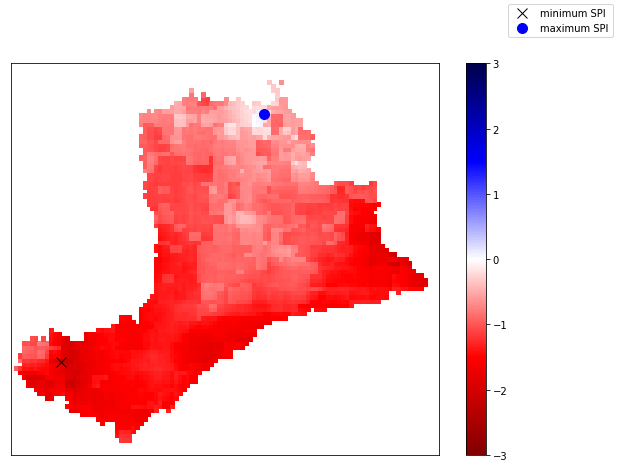

In [553]:
spi_data_t = spi_mask[100,:,:]

vmin = -3
vmax = 3

figscale = 0.8
figsize(12*figscale,9*figscale)
fig,ax = plt.subplots()

im = ax.pcolormesh(spi_data_t, vmin=vmin, vmax=vmax, cmap='seismic_r')

# what pixels have max/min
# NOTE: have to swap the indexes (0,1) -> (1,0)
ix_min = np.unravel_index(ma.MaskedArray.argmin(spi_data_t), spi_data_t.shape)
ix_max = np.unravel_index(ma.MaskedArray.argmax(spi_data_t), spi_data_t.shape)
plt.plot(ix_min[1], ix_min[0], 'kx', markersize=10, linewidth=10, label="minimum SPI")
plt.plot(ix_max[1], ix_max[0], 'bo', markersize=10, linewidth=10, label="maximum SPI")

# hide the axes labels (meaningless dims)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# zoom in to the correct area
ax.set_ylim(55, 148)
ax.set_xlim(58, 168)

fig.colorbar(im)
fig.legend()
plt.show()

In [557]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]

vmin = -3
vmax = 3

def create_annual_SPI_plots(year_start=2016, savefig=False, fig_scale=1):
    figsize(18*fig_scale, 12*fig_scale)
    while year_start < 2017:
        # 1981 = 0, 2016 = 36
        i = 1 * (year_start - 1981)
        print(year_start)
        
        fig, axarr = plt.subplots(3,4, sharex='all', sharey='all')
        spi_mask_t = spi_mask[i*12 : (i*12)+12, :, :]
        i += 1
        
        yr = year_start
        for ts in range(spi_mask_t.shape[0]):
                
            # get the axis to plot the awash map
            mnth = ts % 12
            ax_ix = np.unravel_index(mnth, (3,4))
            ax = axarr[ax_ix[0], ax_ix[1]]

            # NB use the MASKED ARRAY for plotting shapes
            data = spi_mask_t[ts, :, :]
            im = ax.pcolormesh(data, cmap='seismic_r', vmin=vmin, vmax=vmax)

            # get the datetime for the header
            dtim = pd.to_datetime(str(datetime_[ts])) 
            d = dtim.strftime('%Y-%m-%d')
            ax.set_title("{}".format(months[mnth]))

            # hide the axes labels (meaningless dims)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            # zoom in to the correct area
            ax.set_ylim(55, 148)
            ax.set_xlim(58, 168)

        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)
        plt.autoscale(tight=True)
        plt.suptitle("SPI {}".format(yr), fontsize=16)
        year_start += 1 # next year
        if savefig:
            fig.savefig('/Users/TommyLees/Desktop/chirps_data/awash_analysis/figures/plot_yrs/{}'.format(yr), dpi=150)
        else:
            plt.show()
        plt.close()


In [560]:
create_annual_SPI_plots(1981, True, 1)

1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]